Title: 8.2 Exercises

Author: Chad Wood

Date: 11 May 2022

Modified By: Chad Wood

Description: This program demonstrates EDA, data cleaning, predictive analytics, model tuning, and model evaluation.

### Instructions

Within the GitHub, you'll find a dataset for Travel Insurance named travel_insurance.csv. This assignment requires you to:
1. Perform EDA (possibly including data cleansing) and feature engineering as needed.
2. Create a model that predicts "Claim" (i.e., Claim is your target variable).
3. Report model metrics appropriate for a classification model.
4. Use the techniques from Week 6 to tune your model. Minimally use cross-fold validation, although hyperparameter tuning is advised.
5. Thoroughly document why you made your programming choice within the Jupyter Notebook as Markdown comments before each (important) code block.

### First imports
Imports are completed in the same cell block where the import is first needed. I find this helps improve readability in jupyter notebook files.

In [166]:
import pandas as pd
data = pd.read_csv('data/travel_insurance.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision (in value)  63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


### General Cleaning
Below, I begin by creating a copy of the data without column 'Gender.' This is because the majority of gender information was missing. Next, in section 1, I create a dictionary to swap out binary elements in select columns with numerical counterparts. Finally, in section 2, I use label encoding to encode the remaining variables. I chose label encoding because one-hot encoding may have hindered performance due to the size of the output.

In [167]:
# Creates copy of data, drops Gender because EDA revealed it's mostly missing
df = data.drop(columns=['Gender']).copy()

## ____________________    Section 1    ____________________
# Used for swaping dict keys for values as keys occur in df
key = dict(
    {'Travel Agency':1, 
      'Airlines':0,
      'Online':1, 
      'Offline':0,
      'Yes':1, 
      'No':0})

# Performs swap using keys, on binary columns
df['Agency Type'] = df['Agency Type'].replace(key)
df['Distribution Channel'] = df['Distribution Channel'].replace(key)
df['Claim'] = df['Claim'].replace(key)

## ____________________    Section 2    ____________________
# Performs steps from section 1 for inputed series
def label_encode(series):
    values = series.unique()
    labels = range(0, len(values))
    return series.replace(dict(zip(values, labels)))

# Replaces columns with label encoded counterparts
df['Agency'] = label_encode(df['Agency'])
df['Product Name'] = label_encode(df['Product Name'])
df['Destination'] = label_encode(df['Destination'])

df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
0,0,1,0,0,0,186,0,-29.0,9.57,81
1,0,1,0,0,0,186,0,-29.0,9.57,71
2,1,1,1,1,0,65,1,-49.5,29.70,32
3,1,1,1,1,0,60,1,-39.6,23.76,32
4,1,1,1,1,0,79,2,-19.8,11.88,41


### Data Split
Below, I create a function to automatically perform a train, validate, test split. It uses numpy to perform the splitting, and even randomizes the rows before hand. The return is two sets train, validate, and test because it also seperates input from output data. I chose this method for its readability, as I find current (more-typical) methods are "messy-looking," if I may.

In [193]:
import numpy as np

# Splits provided df into three ways (six total; input and target setsg). 
def tri_split(df, target: str, train: float, validation: float, test: float):
    
    # Verifies args equal 100%
    if sum([train, validation, test]) != 1:
        raise ValueError('Sum of sizes is not equal to one.')
    
    # Collects indices for each split, then splits
    indices = [int(train*len(df)), int((train+validation)*len(df))]
    train, validate, test = np.split(df.sample(frac=1), indices)
    
    # Splits input data from target data
    return dict(
        X_train = train.drop(columns=[target]).to_numpy(), 
        y_train = train[target].to_numpy(),
        X_vali   = validate.drop(columns=[target]).to_numpy(), 
        y_vali   = validate[target].to_numpy(),
        X_test  = test.drop(columns=[target]).to_numpy(), 
        y_test  = test[target].to_numpy())


data_dict = tri_split(df, target='Claim', train=0.65, validation=0.15, test=0.2)

### Making Initial Predictions
Below I instantiate the model and fit the data fit it. Then, I get predictions for the validation set. I chose a decision tree because it has a good retupation for flexability when performing categorical predictions on data. One example is its ability to handle missing values.

In [194]:
from sklearn.tree import DecisionTreeClassifier

# Fits data to model
DT = DecisionTreeClassifier()
DT.fit(data_dict.get('X_train'), data_dict.get('y_train'))

# Collects predictions
pred = DT.predict(data_dict.get('X_vali'))

### Initial Evaluation
The evaluation performed below will be used to understand how the model could be improved. I chose accuracy and F1 because they should both be complimentary statistics for understanding how the model may be biased. Accuracy alone is generally not a good enough evaluation (see why below).

In [195]:
from sklearn.metrics import f1_score, accuracy_score

# Collects evaluation metrics
accuracy = accuracy_score(data_dict.get('y_vali'), pred)
f1 = f1_score(data_dict.get('y_vali'), pred)

print(f'Accuracy: {accuracy}')
print(f'F1: {f1}')

Accuracy: 0.9706284872091799
F1: 0.0668896321070234


The model shows very poor performance with its F1 score (0-9), despite having a high accuracy. This means the model is likely overpredicting a certain value. I move forward by creating a function for displaying a confusion matrix. Then, I display the matrix for these predictions.

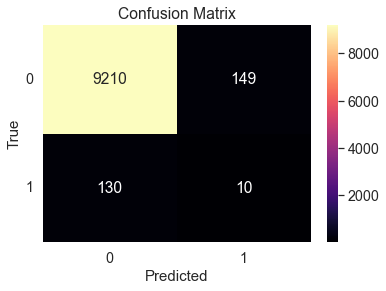

<Figure size 720x504 with 0 Axes>

In [196]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Plots a confusion matrix from args
def plot_confusion(true, pred, labels):
    # Calculates confusion matrix
    confusion_matrix = metrics.confusion_matrix(true, pred)
    matrix_df = pd.DataFrame(confusion_matrix)

    # Plot results in heatmap
    ax = plt.axes()
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.3)
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")

    # Set elements
    ax.set_title('Confusion Matrix')
    ax.set_xlabel("Predicted", fontsize =15)
    ax.set_xticklabels(labels)
    ax.set_ylabel("True", fontsize=15)
    ax.set_yticklabels(list(labels), rotation = 0)

    plt.show()

# Plots confustion matrix
plot_confusion(true=data_dict.get('y_vali'), pred=pred, labels=[0,1])

### Model Tuning
Below, I start by using a linestring to list all perameters for sklearn's decision tree. From there, I decided to focus on parameters that seemed to be useful in balancing a models performance when it's overpredicting. I then use GridSearch to test the performance of the model with each parameter given in an iterable of parameter options. I isolate the best parameters and display them for view.

In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

'''
Decision Tree Hyperparameters:
    criterion                = 'gini', # Method for node splitting; 2% disagreement in general
    splitter                 = 'best', # For computational overhead
    max_depth                = None,   # Node splits; careful of overfitting
    min_samples_split        = 2,      # Node splits; careful of underfitting
    min_samples_leaf         = 1,      # Samples required per leaf; careful of underfitting
    min_weight_fraction_leaf = 0.0,    # Fraction of nodes required for weighting
    max_features             = None,   # Max features per split; careful of underfitting
    random_state             = None,   # The notorious random_state...
    max_leaf_nodes           = None,   # The max nodes per leaf; careful of overfitting
    min_impurity_decrease    = 0.0,    # Min impurity decrease required to split classes
    class_weight             = None,   # Adds weights/bias for classes; helpful in balancing
    ccp_alpha                = 0.0     # Overall impurity improvement threshhold required for split
'''

# Creates parameter tuning dit
params = dict(
    min_samples_split=list(range(2,5)),
    min_samples_leaf=list(range(1,5)),
    max_features=list(range(1,5))
)

# Creates gridSearch
cvFold = RepeatedKFold(n_splits=10, n_repeats=3)
gridSearch = GridSearchCV(estimator=DT, 
                          param_grid=params, 
                          n_jobs=-1, 
                          cv=cvFold, 
                          scoring='f1', 
                          refit=True)

# Fits data to gridSearch; display best configuration
searchResults = gridSearch.fit(data_dict.get('X_train'), data_dict.get('y_train'))
searchResults.best_params_

{'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Finally, I perform the same evaluation steps as before to display accuracy, f1, and the confusion matrix. The results indicate that f1 score has improved to nearly double its original value, though it is still relatively small. The model, depspite its improvement, is still heavily biased toward Claim=0. An alternative attempt was made to create an equal volume of instances where Case = 1 or 0. However, due to there only being ~900 cases of Claim=0, accuracy suffered severely as a result and this change was quickly reverted. I would be interested to know I could have allowed the model to perform better.

Accuracy: 0.9726038212537502
F1: 0.11253196930946292


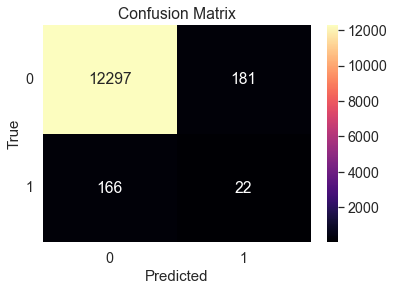

<Figure size 720x504 with 0 Axes>

In [198]:
test_pred = searchResults.best_estimator_.predict(data_dict.get('X_test'))

# Collects evaluation metrics
accuracy = accuracy_score(data_dict.get('y_test'), test_pred)
f1 = f1_score(data_dict.get('y_test'), test_pred)

# Prints evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'F1: {f1}')

# Displays confusion matrix
plot_confusion(true=data_dict.get('y_test'), pred=test_pred, labels=[0,1])